In [105]:
#Python version 3.11.8
#Jupyter Notebook version 7.0.8
import numpy as np # version 1.26.4
from scipy import stats # version 1.14.1
import pandas as pd # version 2.2.3
import matplotlib.pyplot as plt # version 3.10.0

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

np.random.seed(15000)

The following levels are considered:
- scramble boundaries: 1 bar (2 seconds)
- scramble boundaries: 2 bars (4 seconds)
- every 3 bars (6 seconds)
- half-phrase: 4 bars (8 seconds)
- every 5 bars (10 seconds)
- phrase: 8 bars (16 seconds)
- half-section: 16 bars (32 seconds)

Final alignment plot (figure 4): each panel in the final plot will show all of the above levels. Each condition is a different color. Musicians and non-musicians will be in separate subplots. 

# Load the data and ground truth

Load the timestamps.

In [109]:
timestamps = pd.read_csv('../data/E3/timestamps_filtered_long.csv')
print(timestamps)

      exp_subject_id Musician  stimulus_set scramble  stim_num   value
0             342236       No             3       1B        14  13.650
1             342236       No             3       1B        14  19.409
2             342236       No             3       1B        14  30.038
3             342236       No             3       1B        14  37.846
4             342236       No             3       1B        14  47.451
...              ...      ...           ...      ...       ...     ...
3696          393230      Yes             1   Intact         3  35.817
3697          393230      Yes             1       2B         1  25.218
3698          393230      Yes             1       2B         1  31.133
3699          393230      Yes             1       2B         1  41.952
3700          393230      Yes             1       2B         1  57.157

[3701 rows x 6 columns]


In [110]:
# load ground truths
gts = pd.read_csv('../data/stimulus_info_E3/ground_truths.csv')
# remove last column (NaNs - IDK why it's there)
gts = gts.drop("Unnamed: 5", axis=1)
print(gts)

      stimulus_set scramble  stim_num  level  boundary_time
0                1   Intact         1     16             34
1                1   Intact         1     16             66
2                1   Intact         1      8             18
3                1   Intact         1      8             34
4                1   Intact         1      8             50
...            ...      ...       ...    ...            ...
3171             4       1B        16      1             52
3172             4       1B        16      1             54
3173             4       1B        16      1             56
3174             4       1B        16      1             58
3175             4       1B        16      1             60

[3176 rows x 5 columns]


# Functions

In [112]:
def compute_ps_chance(data, gt, window_before=0.25, window_after=1.0, samples=1000):
    ''' 
    Computes precision, sensitivity, and alignment (F) for single subject, single condition - used within `ps_wrapper`

    Default window before is 0.25 seconds, default window after is 1.0 seconds. Number of samples used to make null distribution is 1000.
    '''
    levels = pd.unique(gt['level'])
    trials = pd.unique(data['stim_num'])
    output = np.zeros([3, len(levels)]) # first dim is precision, sensitivity, F; second dim is each level

    for level in range(len(levels)):
        # what are the ground truth boundary times for this level?
        these_gt_vals_both = gt[gt['level'] == levels[level]]

        # set up list to hold both trials
        precision = []
        sensitivity = []
        avg_chance_precision = []
        avg_chance_sensitivity = []

        for tr in trials:
            # grab the responses for this trial
            these_responses = data[data['stim_num'] == tr]['value'].to_numpy()
            total_responses = np.shape(these_responses)[0]
            these_gt_vals = these_gt_vals_both[these_gt_vals_both['stim_num'] == tr]['boundary_time'].to_numpy()

            # compute the number of "in window responses"
            # for each GT boundary, is there a response in the window around that?
            in_window_response_by_bound = np.zeros(these_gt_vals.shape[0])
            for w in range(len(these_gt_vals)):
                # define the "in-window" range
                range_before = these_gt_vals[w] - window_before
                range_after = these_gt_vals[w] + window_after

                # for each response, check if the response is in the range
                for r in these_responses:
                    if r > range_before and r <= range_after: 
                        # if it is, set the corresponding in-window count to 1
                        in_window_response_by_bound[w] = 1 # this prevents double-counting
                    # otherwise do nothing

            in_window_responses = np.sum(in_window_response_by_bound)

            # compute precision and sensitivity
            precision.append(in_window_responses / total_responses)
            sensitivity.append(in_window_responses / np.shape(these_gt_vals)[0])

            # compute chance using a bootstrap approach
            # lists to hold results from many samples
            chance_precision = []
            chance_sensitivity = []

            for sample in range(samples):
                # generate random responses
                responses_random = np.random.rand(total_responses) * 68 # to account for length of trial

                # compute the number of "in window responses"
                # for each GT boundary, is there a response in the window around that?
                in_window_response_by_bound = np.zeros(these_gt_vals.shape[0])
                for w in range(len(these_gt_vals)):
                    # define the "in-window" range
                    range_before = these_gt_vals[w] - window_before
                    range_after = these_gt_vals[w] + window_after

                    # for each response, check if the response is in the range
                    for r in responses_random:
                        if r > range_before and r <= range_after: 
                            # if it is, set the corresponding in-window count to 1
                            in_window_response_by_bound[w] = 1 # this prevents double-counting
                        # otherwise do nothing

                in_window_responses = np.sum(in_window_response_by_bound)

                chance_precision.append(in_window_responses / total_responses)
                chance_sensitivity.append(in_window_responses / np.shape(these_gt_vals)[0])

            avg_chance_precision.append(np.mean(chance_precision))
            avg_chance_sensitivity.append(np.mean(chance_sensitivity))

        # take the mean and adjust for chance
        precision_mean_adj = np.mean(precision) - np.mean(avg_chance_precision)
        sensitivity_mean_adj = np.mean(sensitivity) - np.mean(avg_chance_sensitivity)
        
        # average precision and sensitivity across trials and save in the output array
        output[0,level] = precision_mean_adj
        output[1,level] = sensitivity_mean_adj
        # compute and save F
        if precision_mean_adj == 0.0 and sensitivity_mean_adj == 0.0: output[2,level] = 0.0
        else: output[2,level] = (2 * precision_mean_adj * sensitivity_mean_adj) / (precision_mean_adj + sensitivity_mean_adj)
        
    return output

In [113]:
def ps_wrapper(data, gt, group, stimulus_set, window_before=0.25, window_after=1.0, samples=1000):

    # all the data gets passed, so first have to filter by group and stimulus set
    this_data = data[data['Musician'] == group]
    this_data = this_data[this_data['stimulus_set'] == stimulus_set]

    # pull out subject ids
    sub_ids = pd.unique(this_data['exp_subject_id'])
    # the conditions array should be defined earlier in the notebook, but copy it here for sanity
    conditions = ['Intact', '8B', '2B', '1B']
    # pull out the levels (compute_ps also does this)
    levels = pd.unique(gt['level'])

    # initialize the output array
    # 3 (P,S,F) x number of subjects x number of conditions x number of levels
    output = np.zeros([3, np.shape(sub_ids)[0], len(conditions), len(levels)])

    # each subject individually
    for s in range(sub_ids.shape[0]):
        this_sub_data = this_data[this_data['exp_subject_id'] == sub_ids[s]]

        # further, filter by condition
        for c in range(len(conditions)):
            this_cond_data = this_sub_data[this_sub_data['scramble'] == conditions[c]]
            if this_cond_data.empty: 
                #print("Subject %s is missing data." %sub_ids[s])
                continue
            this_gt = gt[gt['scramble'] == conditions[c]]

            output[:,s,c,:] = compute_ps_chance(this_cond_data, this_gt, 
                                                window_before=window_before, window_after=window_after, samples=samples)
    
    print('done with group: %s, stimulus set: %d' %(group, stimulus_set))
            
    return output

# Compute precision, sensitivity, and overall alignment

`ps_wrapper` takes one group (musician/non-musician) and one stimulus set at a time.

In [116]:
psf_M_1 = ps_wrapper(timestamps, gts, group='Yes', stimulus_set=1)
psf_M_3 = ps_wrapper(timestamps, gts, group='Yes', stimulus_set=3)
psf_M_4 = ps_wrapper(timestamps, gts, group='Yes', stimulus_set=4)
psf_NM_1 = ps_wrapper(timestamps, gts, group='No', stimulus_set=1)
psf_NM_3 = ps_wrapper(timestamps, gts, group='No', stimulus_set=3)
psf_NM_4 = ps_wrapper(timestamps, gts, group='No', stimulus_set=4)
# this cell takes a bit

done with group: Yes, stimulus set: 1
done with group: Yes, stimulus set: 3
done with group: Yes, stimulus set: 4
done with group: No, stimulus set: 1
done with group: No, stimulus set: 3
done with group: No, stimulus set: 4


Combine all stimulus sets.

In [118]:
psf_M_all = np.concatenate((psf_M_1, psf_M_3, psf_M_4), axis = 1)
psf_NM_all = np.concatenate((psf_NM_1, psf_NM_3, psf_NM_4), axis = 1)

In [119]:
print(np.shape(psf_M_all))
print(np.shape(psf_NM_all))

(3, 49, 4, 7)
(3, 46, 4, 7)


Data structure is P/S/F x number of subjects x condition x levels.

## Save alignment values

Wrangle F values into a long form with labels so we can read it in R.

In [123]:
levels = ['16', '8', '5', '4', '3', '2', '1']

In [124]:
f = psf_M_all[2,:,:,:]

Separate each condition and save as a separate dataframe

In [126]:
f_I = pd.DataFrame(f[:,0,:], columns = levels)
f_I.insert(0, 'scramble', 'Intact')
f_8B = pd.DataFrame(f[:,1,:], columns = levels)
f_8B.insert(0, 'scramble', '8B')
f_2B = pd.DataFrame(f[:,2,:], columns = levels)
f_2B.insert(0, 'scramble', '2B')
f_1B = pd.DataFrame(f[:,3,:], columns = levels)
f_1B.insert(0, 'scramble', '1B')

In [127]:
# concatenate
f_M = pd.concat([f_I, f_8B, f_2B, f_1B])
# reset index so we have a subject column
f_M = f_M.reset_index()
f_M = f_M.rename(columns = {"index": "sub"})
# add a group column
f_M.insert(0, 'Musician', 'Yes')

In [128]:
print(f_M)

    Musician  sub scramble        16         8         5         4         3  \
0        Yes    0   Intact  0.096013  0.029285 -0.051175 -0.012511  0.005146   
1        Yes    1   Intact  0.137183 -0.072432 -0.029492 -0.131382 -0.075163   
2        Yes    2   Intact -0.051250 -0.061786 -0.065350 -0.071192 -0.067824   
3        Yes    3   Intact  0.444565  0.223877 -0.017533  0.090388  0.026261   
4        Yes    4   Intact -0.044449 -0.053250 -0.048464 -0.050892 -0.054180   
..       ...  ...      ...       ...       ...       ...       ...       ...   
191      Yes   44       1B  0.000000  0.000000  0.000000  0.000000  0.000000   
192      Yes   45       1B -0.064031 -0.074558  0.162690 -0.094976 -0.015442   
193      Yes   46       1B  0.194586  0.215639 -0.021815  0.230268 -0.082814   
194      Yes   47       1B  0.109600  0.305000  0.302222  0.118636  0.044929   
195      Yes   48       1B  0.078167 -0.016000  0.032500 -0.018250  0.060067   

            2         1  
0    0.008952

Repeat for non-musicians

In [130]:
f = psf_NM_all[2,:,:,:]

f_I = pd.DataFrame(f[:,0,:], columns = levels)
f_I.insert(0, 'scramble', 'Intact')
f_8B = pd.DataFrame(f[:,1,:], columns = levels)
f_8B.insert(0, 'scramble', '8B')
f_2B = pd.DataFrame(f[:,2,:], columns = levels)
f_2B.insert(0, 'scramble', '2B')
f_1B = pd.DataFrame(f[:,3,:], columns = levels)
f_1B.insert(0, 'scramble', '1B')

# concatenate
f_NM = pd.concat([f_I, f_8B, f_2B, f_1B])
# reset index so we have a subject column
f_NM = f_NM.reset_index()
f_NM = f_NM.rename(columns = {"index": "sub"})
# add a group column
f_NM.insert(0, 'Musician', 'No')

In [131]:
print(f_NM)

    Musician  sub scramble        16         8         5         4         3  \
0         No    0   Intact -0.029143 -0.038923 -0.034316 -0.035200 -0.036485   
1         No    1   Intact -0.044546 -0.052971 -0.047825 -0.053673 -0.051600   
2         No    2   Intact -0.103004  0.051531 -0.059268  0.025303  0.066033   
3         No    3   Intact  0.180698  0.065067 -0.078069 -0.004455 -0.083394   
4         No    4   Intact -0.069962 -0.139500  0.023090 -0.072699  0.110075   
..       ...  ...      ...       ...       ...       ...       ...       ...   
179       No   41       1B  0.044295  0.201858  0.047081  0.237225  0.191326   
180       No   42       1B -0.051833 -0.059100 -0.062286 -0.068968  0.021771   
181       No   43       1B -0.051519 -0.072929  0.205433  0.023687  0.073607   
182       No   44       1B  0.069377 -0.014437  0.022531 -0.112473 -0.032979   
183       No   45       1B -0.081765  0.044096  0.213140  0.044672 -0.115679   

            2         1  
0   -0.037388

Concatenate across both groups and save

In [133]:
f_all = pd.concat([f_M, f_NM])
f_all.to_csv('../data/E3/alignment.csv', index = False)

Only issue is that both musicians and non-musicans are both labelled 0-44. This is addressed in `E3_alignment.Rmd`

# Plot alignment values

In [136]:
conditions = ['Intact', '8B', '2B', '1B']
cond_colors = ['red', 'orange',  'green', 'blue']
cond_jitter = [-.225, -.075, .075, .225]
levels = np.asarray([1,2,3,4,5,8,16])
levels = np.flip(levels)

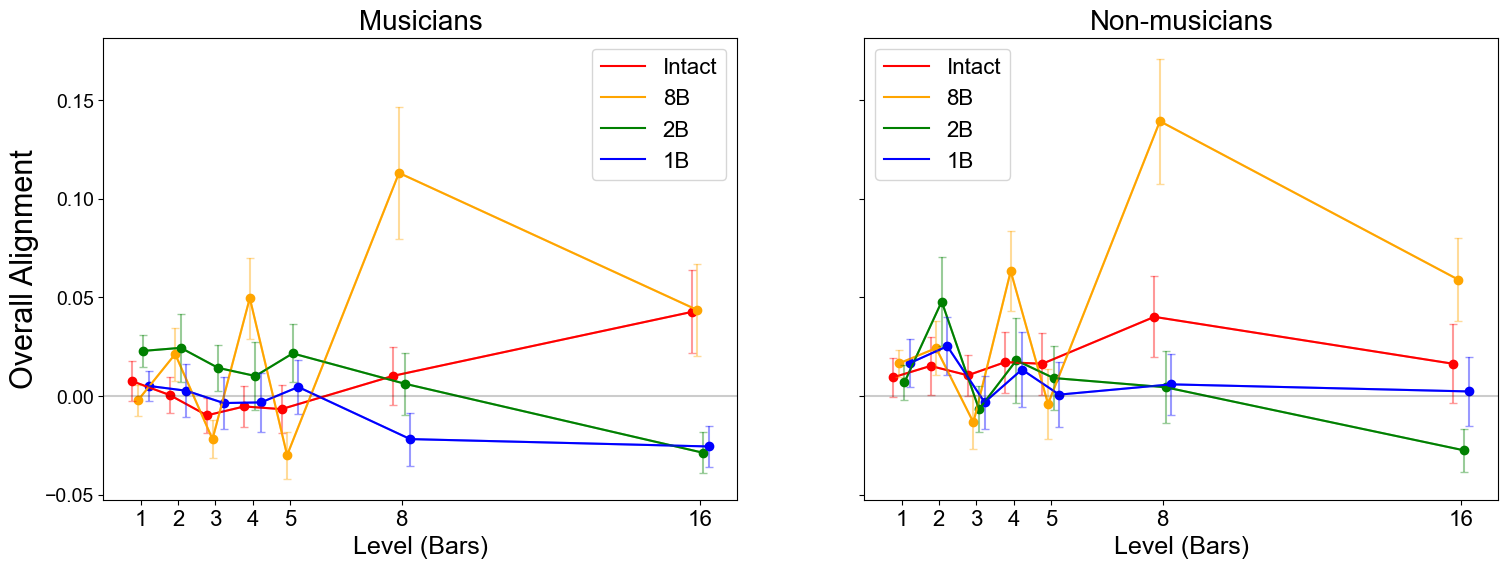

In [137]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize = (18,6))
#plt.tight_layout()

for c in range(len(conditions)):  
    ax[0].plot(levels + cond_jitter[c], np.mean(psf_M_all[2,:,c,:], axis=0), color = cond_colors[c], alpha = 1, label = conditions[c])
    ax[0].scatter(levels + cond_jitter[c], np.mean(psf_M_all[2,:,c,:], axis=0), color = cond_colors[c], alpha = 1)
    ax[0].errorbar(levels + cond_jitter[c], np.mean(psf_M_all[2,:,c,:], axis=0), yerr = stats.sem(psf_M_all[2,:,c,:], axis=0),
                   color = cond_colors[c], capsize = 3, alpha = 0.4)
    
    ax[1].plot(levels + cond_jitter[c], np.nanmean(psf_NM_all[2,:,c,:], axis=0), color = cond_colors[c], alpha = 1, 
               label = conditions[c])
    ax[1].scatter(levels + cond_jitter[c], np.nanmean(psf_NM_all[2,:,c,:], axis=0), color = cond_colors[c], alpha = 1)
    ax[1].errorbar(levels + cond_jitter[c], np.nanmean(psf_NM_all[2,:,c,:], axis=0), 
                   yerr = stats.sem(psf_NM_all[2,:,c,:], axis=0, nan_policy = 'omit'),
                   color = cond_colors[c], capsize = 3, alpha = 0.4)

ax[0].set_ylabel('Overall Alignment', fontsize = 22)
ax[0].set_title('Musicians', fontsize = 20)
ax[1].set_title('Non-musicians', fontsize = 20)

for col in range(2):
    ax[col].set_xlim(0, 17)
    ax[col].hlines(0,17,0, color = 'black', alpha = 0.2)
    ax[col].set_xticks(levels)
    ax[col].set_xticklabels(levels, fontsize = 16)
    ax[col].tick_params(axis='y', which='major', labelsize=14)
    ax[col].set_xlabel('Level (Bars)', fontsize = 18)
    ax[col].legend(fontsize=16)

plt.savefig('../figures/Fig4_alignment.png', dpi=500)